In [1]:
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import ward
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics

from os import listdir
from os.path import isfile, join

# Converting Scraped Data to Dataframe

In [2]:
def read_speeches(fp):
    '''Convert Pickled Nested Dictionary to a pandas DataFrame'''
    p1 = pd.read_pickle(fp)
    all_speech = pd.DataFrame()

    for pres in p1.keys():
        d = p1[pres]['Date']
        this_pres = pd.DataFrame({
                'president': [pres]*len(d),
                'date': d,
                'title': p1[pres]['NoS'],
                'speech': p1[pres]['Speech']
            })
        all_speech = all_speech.append(this_pres)
    return all_speech

fp = 'SpeechDictionary_complete.pkl'
speeches = read_speeches(fp)

# Replacing with Translated Speeches

For speeches containing non-English words and explitives, the group utilized both google translate and our own grasp of the language to translate the files.

In [3]:
def translate(speech):
    files = [f for f in listdir('./Translated')
             if isfile(join('./Translated', f))]
    translated = pd.DataFrame(columns=['year', 'speech'])

    for item in files:
        with open('./Translated/'+item) as f:
            df = pd.read_csv(f, delimiter='/t', header=None)
            translated = translated.append(
                                    {'year': item[:-4],
                                     'speech': df[0].str.cat(sep="/t")},
                                     ignore_index=True
                                  )
    for row, entry in enumerate(translated.year.unique()):
        speeches.loc[speeches.date == entry,
                     'speech'] = translated['speech'][row]

    return speeches

speeches = translate(speeches)
speeches

<ipython-input-3-19790334fcbe>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(f, delimiter='/t', header=None)


,president,date,title,speech
0,Manuel L. Quezon,"November 25, 1935",Message to the First Assembly on National Defense,\n\n\nMessage\nof\nHis Excellency Manuel L. Qu...
1,Manuel L. Quezon,"June 16, 1936",On the Country’s Conditions and Problems,\n\n\nMessage\nof\nHis Excellency Manuel L. Qu...
2,Manuel L. Quezon,"October 18, 1937","Improvement of Philippine Conditions, Philippi...",\n\n\nMessage\nof\nHis Excellency Manuel L. Qu...
3,Manuel L. Quezon,"January 24, 1938",Revision of the System of Taxation,\n\n\nMessage\nof\nHis Excellency Manuel L. Qu...
4,Manuel L. Quezon,"January 24, 1939",The State of the Nation and Important Economic...,\n\n\nMessage\nof\nHis Excellency Manuel L. Qu...
...,...,...,...,...
1,Rodrigo Roa Duterte,"July 24, 2017",Second State of the Nation Address,Kindly sit down. Thank you for your courtesy./...
2,Rodrigo Roa Duterte,"July 23, 2018",Third State of the Nation Address,Senate President Vicente Sotto III and the mem...
3,Rodrigo Roa Duterte,"July 22, 2019",Fourth State of the Nation Address,Thank you. Kindly sit down. How are you?/tSena...
4,Rodrigo Roa Duterte,"July 27, 2020",Fifth State of the Nation Address,Kindly/tSenate President Vicente Sotto III and...


# Cleaning Speeches

* Removing trailing whitespaces
* Replace whitespaces (`\t`,`\n`).
* Changing special characters (`'`, `"`)
* Replacing `US` to `United States`
* Replacing `Barangays` to `Barangay`

This was done to avoid wrong lemmatization for these words since they are not common english words.

In [4]:
speeches["speech"] = speeches["speech"].replace(r'\n', ' ', regex=True) 
speeches["speech"] = speeches["speech"].replace(r'\t', ' ', regex=True) 
speeches["speech"] = speeches["speech"].replace(r' \d+', ' ', regex=True)
speeches["speech"] = speeches["speech"].replace(r"'", '', regex=True)
speeches["speech"] = speeches["speech"].replace(r"’", '', regex=True)
speeches["speech"] = speeches["speech"].replace(r'/t', ' ', regex=True)
speeches["speech"] = speeches["speech"].replace(r"U. S.", 'United States', regex=True)
speeches["speech"] = speeches["speech"].replace(r"U.S.", 'United States', regex=True)
speeches["speech"] = speeches["speech"].replace(r"barangays", 'barangay', regex=True)
speeches["speech"] = speeches["speech"].str.lower()

speeches.to_csv('cleaned_speeches.csv')

# Data Preparation for Lematization & TF-IDF

## Lematize

In [5]:
import nltk 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#Tokenization
speeches['tokenized'] = speeches['speech'].apply(word_tokenize)

#Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

speeches['tokenized'] = speeches['tokenized'].apply(lemmatize_text)
speeches['tokenized_2'] = speeches['tokenized'].str.join(" ")
speeches

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/msds2022/jlas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2022/jlas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2022/jlas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,president,date,title,speech,tokenized,tokenized_2
0,Manuel L. Quezon,"November 25, 1935",Message to the First Assembly on National Defense,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...
1,Manuel L. Quezon,"June 16, 1936",On the Country’s Conditions and Problems,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...
2,Manuel L. Quezon,"October 18, 1937","Improvement of Philippine Conditions, Philippi...",message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...
3,Manuel L. Quezon,"January 24, 1938",Revision of the System of Taxation,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...
4,Manuel L. Quezon,"January 24, 1939",The State of the Nation and Important Economic...,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...
...,...,...,...,...,...,...
1,Rodrigo Roa Duterte,"July 24, 2017",Second State of the Nation Address,kindly sit down. thank you for your courtesy. ...,"[kindly, sit, down, ., thank, you, for, your, ...",kindly sit down . thank you for your courtesy ...
2,Rodrigo Roa Duterte,"July 23, 2018",Third State of the Nation Address,senate president vicente sotto iii and the mem...,"[senate, president, vicente, sotto, iii, and, ...",senate president vicente sotto iii and the mem...
3,Rodrigo Roa Duterte,"July 22, 2019",Fourth State of the Nation Address,thank you. kindly sit down. how are you? senat...,"[thank, you, ., kindly, sit, down, ., how, are...",thank you . kindly sit down . how are you ? se...
4,Rodrigo Roa Duterte,"July 27, 2020",Fifth State of the Nation Address,kindly senate president vicente sotto iii and ...,"[kindly, senate, president, vicente, sotto, ii...",kindly senate president vicente sotto iii and ...


# TF-IDF

Additional Filipino stopwords were added to capture instances that were not detected

## Performing TF-IDF

In [6]:
newStopWords = ['ha','wa', 'u', 'applause', 
                "ng","sa","na","mga","ang","ay","at","isang","ito",
                "ni","may","bilang","si","hindi","noong","mula",
                "para","kung","nito","pang","tao","pag","upang",
                "kanyang","siya","iba","rin","ibang","kanilang",
                "dahil","pa","lamang","isa","din","maaaring","nasa",
                "niya","nang","pamamagitan","kay","hanggang","ilang",
                "akin","aking","ako","alin","am","amin","aming","ang",
                "ano","anumang","apat","at","atin","ating","ay",
                "bababa","bago","bakit","bawat","bilang","dahil",
                "dalawa","dapat","din","dito","doon","gagawin",
                "gayunman","ginagawa","ginawa","ginawang","gumawa",
                "gusto","habang","hanggang","hindi","huwag","iba",
                "ibaba","ibabaw","ibig","ikaw","ilagay","ilalim",
                "ilan","inyong","isa","isang","itaas","ito","iyo",
                "iyon","iyong","ka","kahit","kailangan","kailanman",
                "kami","kanila","kanilang","kanino","kanya","kanyang",
                "kapag","kapwa","karamihan","katiyakan","katulad",
                "kaya","kaysa","ko","kong","kulang","kumuha","kung",
                "laban","lahat","lamang","likod","lima","maaari",
                "maaaring","maging","mahusay","makita","marami",
                "marapat","masyado","may","mayroon","mga","minsan",
                "mismo","mula","muli","na","nabanggit","naging",
                "nagkaroon","nais","nakita","namin","napaka","narito",
                "nasaan","ng","ngayon","ni","nila","nilang","nito",
                "niya","niyang","noon","o","pa","paano","pababa",
                "paggawa","pagitan","pagkakaroon","pagkatapos",
                "palabas","pamamagitan","panahon","pangalawa","para",
                "paraan","pareho","pataas","pero","pumunta",
                "pumupunta","sa","saan","sabi","sabihin","sarili",
                "sila","sino","siya","tatlo","tayo","tulad",
                "tungkol","una","wala", "walang",
                'www','youtube','com','http', 'translated', 'transcript']

my_stop_words = text.ENGLISH_STOP_WORDS.union(newStopWords)

tfidfvec = TfidfVectorizer(stop_words=my_stop_words,
                           token_pattern=u'(?ui)\\b[a-z]+\\b',
                           ngram_range=(2,2))

tfidf_tokenized = tfidfvec.fit_transform(speeches["tokenized_2"])
feature_array = tfidfvec.get_feature_names()

print(len(feature_array))
df_tfidf = pd.DataFrame(tfidf_tokenized.toarray(), columns=feature_array)
df_tfidf

218395


,aabot bilyon,aabot pinakamababa,aapat porsiento,ab just,ab rappler,abaca cent,abaca chip,abaca cited,abaca coconut,abaca commodity,...,zoom sorsogon,zoomed im,zoomed owing,zooming double,zopad southern,zopad spcpd,zte scandal,zubiri mindanao,zubiri sponsoring,zubiri term
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.0,0.0,0.0,0.014099,0.014099,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Saving TF-IDF

In [7]:
pd.set_option('display.max_rows', 500)
sums = tfidf_tokenized.sum(axis=0)

# Connecting term to its sums frequency
data = []
for col, term in enumerate(feature_array):
    data.append((term, sums[0,col]))

ranking = pd.DataFrame(data, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
#rank.to_csv('tfidf_all.csv')

# Dimensionality Reduction

83


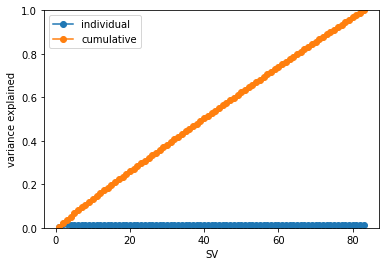

In [8]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=83)
svd_model.fit(tfidf_tokenized)
svd_results = svd_model.fit_transform(tfidf_tokenized)
ve = svd_model.explained_variance_ratio_
print(len(ve.cumsum() < 1))

fig, ax = plt.subplots()
ax.plot(range(1, len(ve)+1), ve, 'o-', label='individual')
ax.plot(range(1, len(ve)+1), ve.cumsum(), 'o-', label='cumulative')
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained');

In [9]:
df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_model.components_):   
    best_features = [(feature_array[n], np.abs(svd_model.components_[i][n]))
                 for n in np.abs(svd_model.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,SV_7,SV_8,SV_9,...,SV_73,SV_74,SV_75,SV_76,SV_77,SV_78,SV_79,SV_80,SV_81,SV_82
0,"(united state, 0.20302572486891673)","(billion peso, 0.09787284967598038)","(united state, 0.1838347327045298)","(batasang pambansa, 0.14302026078998822)","(tenth congress, 0.08441726014625002)","(dont know, 0.09957141578218044)","(united state, 0.0816595120239059)","(united state, 0.11727792642568163)","(strong republic, 0.11109219586292347)","(socio economic, 0.09402150538382513)",...,"(peace development, 0.04488814465545234)","(tenth congress, 0.06109609828944934)","(foreign exchange, 0.04615158007667509)","(civic action, 0.04823690070480204)","(class road, 0.04342406204280731)","(rate population, 0.029837896508005383)","(complete independence, 0.10525349427240842)","(fiscal year, 0.04407969714694951)","(surplus property, 0.08761373519845649)","(new filipinism, 0.07819880639764325)"
1,"(economic development, 0.11246560144566457)","(metro manila, 0.08378061418395678)","(national assembly, 0.1503491137807667)","(national assembly, 0.11770312950132061)","(lady gentleman, 0.06949738250369233)","(illegal drug, 0.07120128383715976)","(pre war, 0.076731749577183)","(pre war, 0.06428057599681777)","(war poverty, 0.04591235561787244)","(north borneo, 0.06596014590172139)",...,"(north borneo, 0.037039246728940885)","(leaving backlog, 0.03747231752869675)","(billion million, 0.03216003117386772)","(fund shall, 0.03082106793707192)","(recommend national, 0.043094943045805086)","(foreign exchange, 0.028137687162388115)","(trade relation, 0.08498013417198243)","(privilege writ, 0.04263043531932162)","(session congress, 0.08347935054152171)","(ice plant, 0.054245122967038276)"
2,"(land reform, 0.08495449112014246)","(congress pas, 0.06028507149058388)","(president roosevelt, 0.07796605265815766)","(crisis government, 0.08759511312558396)","(ask congress, 0.06104609440851744)","(dont want, 0.06878573763962549)","(million peso, 0.07327932469111642)","(state government, 0.05589709538128785)","(ask congress, 0.04026514368937317)","(united state, 0.06490091794726269)",...,"(competitiveness report, 0.03251871932239769)","(vaulting strategy, 0.030390677755644177)","(leaving backlog, 0.027441376255783943)","(domestic saving, 0.028946999936492208)","(submitted people, 0.03561244058887872)","(trade zone, 0.025542767957614326)","(high commissioner, 0.07022311164217904)","(increase million, 0.042584951507206474)","(pre war, 0.04184702478347283)","(ordered dismissal, 0.052132537598428855)"
3,"(past year, 0.08216241402316513)","(ask congress, 0.054316734612529824)","(billion peso, 0.07420871895525746)","(new society, 0.08332499186538096)","(peace development, 0.05420058592050069)","(just like, 0.05675812558364258)","(batasang pambansa, 0.05338440482534116)","(surplus property, 0.05354353816755439)","(charter change, 0.04007076979536774)","(president roosevelt, 0.05368833834756111)",...,"(area autonomy, 0.03251871932239769)","(ramos administration, 0.030390677755644177)","(philippine cultural, 0.026412454993588068)","(fiscal year, 0.028131696655946285)","(value property, 0.03302659850178923)","(payment problem, 0.025475577178817047)","(chairman committee, 0.05090089036344047)","(development plan, 0.0416506704468289)","(past month, 0.038015969741310586)","(metropolitan area, 0.04892551686216397)"
4,"(development program, 0.07923272674290702)","(dont know, 0.0467466933011214)","(filipino people, 0.07096466766303189)","(martial law, 0.07455499943504962)","(congress pas, 0.052417808186415164)","(build build, 0.0499739549092985)","(state government, 0.046205298025907934)","(land reform, 0.04581666288965021)","(food table, 0.03907574947193399)","(economic program, 0.05075224589822693)",...,"(world competitiveness, 0.029854138319363534)","(pole vaulting, 0.030390677755644177)","(actual actual, 0.026412454993588068)","(specific tax, 0.023675858733156405)","(independence act, 0.02877948479221787)","(land authority, 0.02331622444149133)","(state p

In [10]:
# Saving SVD results
speech = speeches['president']+'-'+speeches['date']
# pd.DataFrame(svd_results, index=speech).to_csv('svd_results_final.csv')

# Clustering

Multiple Iterations were performed to identify the best method/threshold for clustering

## Iteration 1 (t = 1.58)

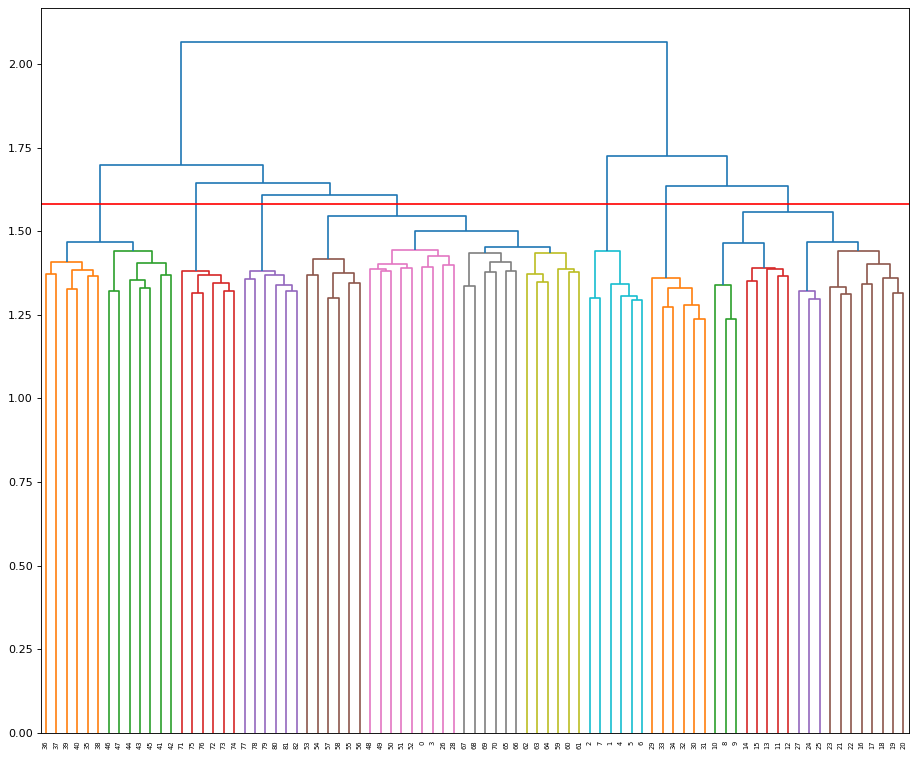

In [11]:
dist = 1 - cosine_similarity(svd_results)
mergings = linkage(dist, method="ward", metric='euclidean')

plt.figure(figsize=(14, 12), dpi=80)
dendrogram(mergings, p=20, truncate_mode="level", leaf_rotation=90)
plt.axhline(y=1.58, c='r')
plt.show()

In [12]:
Z = linkage(dist, method="ward", metric='euclidean', optimal_ordering=True)
y_predict_Z = fcluster(Z, t=1.58, criterion='distance')

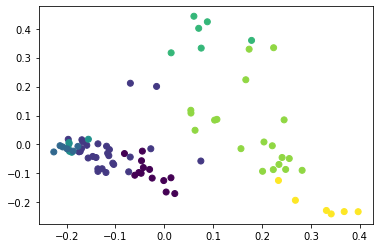

In [13]:
X_res_new = PCA(n_components=2, random_state=1337).fit_transform(dist)
plt.scatter(X_res_new[:,0], X_res_new[:,1], c=y_predict_Z);

In [14]:
print(metrics.silhouette_score(svd_results, y_predict_Z, metric='euclidean'))
print(metrics.calinski_harabasz_score(svd_results, y_predict_Z))

0.004439722463877131
1.2484071650997082


In [15]:
cluster_labels = cut_tree(mergings, n_clusters=7).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6])

In [16]:
speeches['clusters'] = y_predict_Z
speeches2 = speeches[['president', 'date', 'clusters']]
speeches2

,president,date,clusters
0,Manuel L. Quezon,"November 25, 1935",2
1,Manuel L. Quezon,"June 16, 1936",5
2,Manuel L. Quezon,"October 18, 1937",5
3,Manuel L. Quezon,"January 24, 1938",2
4,Manuel L. Quezon,"January 24, 1939",5
5,Manuel L. Quezon,"January 22, 1940",5
6,Manuel L. Quezon,"January 31, 1941",5
0,Sergio Osmeña,"June 9, 1945",5
0,Manuel Roxas,"June 3, 1946",6
1,Manuel Roxas,"January 27, 1947",6


## Iteration 2 (t = 1.67) ; Best Iteration

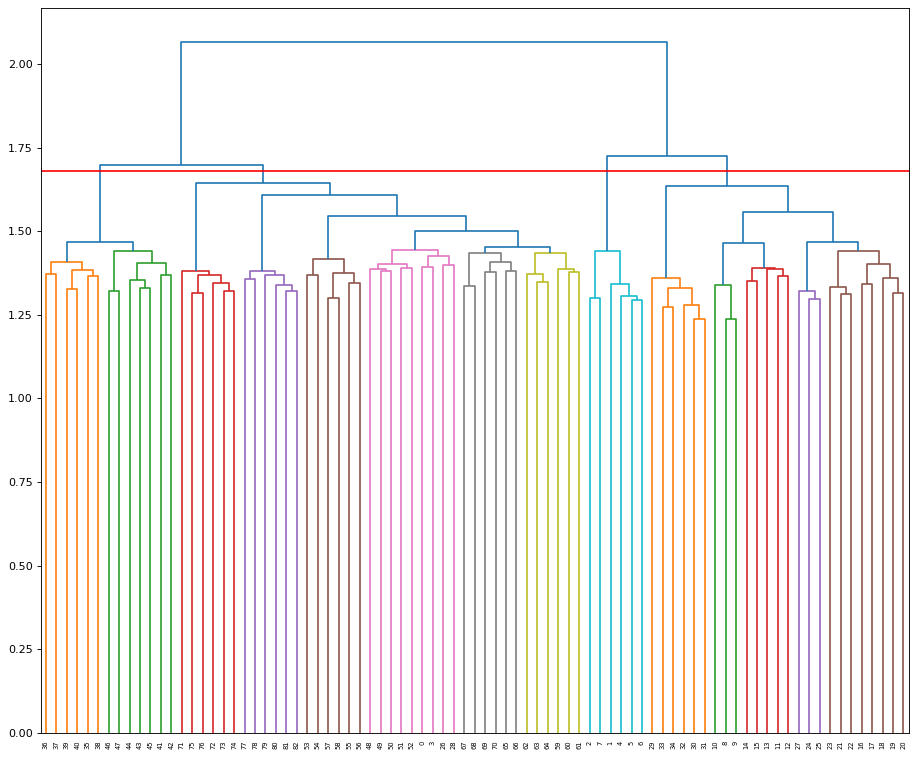

In [17]:
dist = 1 - cosine_similarity(svd_results)
mergings2 = linkage(dist, method="ward", metric='euclidean')

plt.figure(figsize=(14, 12), dpi=80)
dendrogram(mergings2, p=20, truncate_mode="level", leaf_rotation=90)
plt.axhline(y=1.67, c='r')
plt.show()

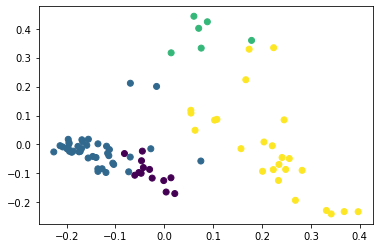

In [18]:
Z2 = linkage(dist, method="ward", metric='euclidean', optimal_ordering=True)
y_predict_Z2 = fcluster(Z2, t=1.67, criterion='distance')
X_res_new = PCA(n_components=2, random_state=1337).fit_transform(dist)
plt.scatter(X_res_new[:,0], X_res_new[:,1], c=y_predict_Z2)

In [19]:
print(metrics.silhouette_score(svd_results, y_predict_Z2, metric='euclidean'))
print(metrics.calinski_harabasz_score(svd_results, y_predict_Z2))

0.005031387914583175
1.306276551557556


### Looking at Misclassified Points

These are points of interest since they didnt cluster with their other speeches

In [20]:
speeches['clusters_2'] = y_predict_Z2
speeches_idx = speeches.reset_index()
speeches_idx[speeches_idx['clusters_2'] == 2]

,index,president,date,title,speech,tokenized,tokenized_2,clusters,clusters_2
0,0,Manuel L. Quezon,"November 25, 1935",Message to the First Assembly on National Defense,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...,2,2
3,3,Manuel L. Quezon,"January 24, 1938",Revision of the System of Taxation,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...,2,2
26,2,Diosdado Macapagal,"January 27, 1964",The State of the Nation,message of his excellency diosdado macapaga...,"[message, of, his, excellency, diosdado, macap...",message of his excellency diosdado macapagal p...,2,2
28,0,Ferdinand E. Marcos,"January 24, 1966",Address on the State of the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,2,2
48,0,Corazon C. Aquino,"July 27, 1987",State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
49,1,Corazon C. Aquino,"July 25, 1988",State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
50,2,Corazon C. Aquino,"July 24, 1989",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
51,3,Corazon C. Aquino,"July 23, 1990",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
52,4,Corazon C. Aquino,"July 22, 1991",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
53,0,Fidel V. Ramos,"July 27, 1992","Reform, Change, and Growth",messageofhis excellency fidel v. ramospresi...,"[messageofhis, excellency, fidel, v., ramospre...",messageofhis excellency fidel v. ramospresiden...,2,2


In [21]:
zeros = np.zeros(83)
indexes = [0,3,26,28]
replacements = [1,1,2,3]

zeros[0] = replacements[1]
zeros[3] = replacements[1]
zeros[26] = replacements[2]
zeros[28] = replacements[3]
zeros

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

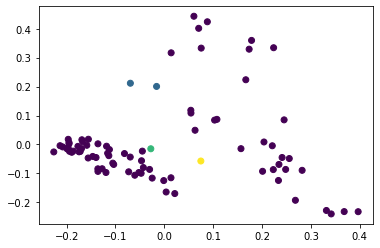

In [22]:
Z2 = linkage(dist, method="ward", metric='euclidean', optimal_ordering=True)
y_predict_Z2 = fcluster(Z2, t=1.68, criterion='distance')
X_res_new = PCA(n_components=2, random_state=1337).fit_transform(dist)
plt.scatter(X_res_new[:,0], X_res_new[:,1], c=zeros)

## Iteration 3

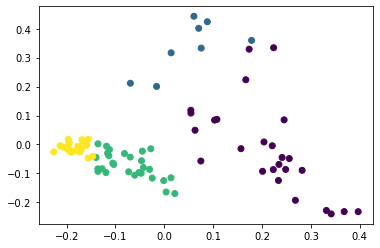

In [23]:
Z2_test = linkage(dist, method="complete", metric='euclidean', optimal_ordering=True)
y_predict_Z2_test = fcluster(Z2_test, t=1.415, criterion='distance')
X_res_new = PCA(n_components=2, random_state=1337).fit_transform(dist)
plt.scatter(X_res_new[:,0], X_res_new[:,1], c=y_predict_Z2_test)

In [24]:
print(metrics.silhouette_score(svd_results, y_predict_Z2_test, metric='euclidean'))
print(metrics.calinski_harabasz_score(svd_results, y_predict_Z2_test))

0.005725113442302209
1.3126416862943133


In [25]:
speeches_test = speeches[['president', 'date']]
speeches_test['cluster'] = y_predict_Z2
speeches_test

<ipython-input-25-e83a9cc4fa3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_test['cluster'] = y_predict_Z2


,president,date,cluster
0,Manuel L. Quezon,"November 25, 1935",2
1,Manuel L. Quezon,"June 16, 1936",3
2,Manuel L. Quezon,"October 18, 1937",3
3,Manuel L. Quezon,"January 24, 1938",2
4,Manuel L. Quezon,"January 24, 1939",3
5,Manuel L. Quezon,"January 22, 1940",3
6,Manuel L. Quezon,"January 31, 1941",3
0,Sergio Osmeña,"June 9, 1945",3
0,Manuel Roxas,"June 3, 1946",4
1,Manuel Roxas,"January 27, 1947",4


In [26]:
speeches['clusters_2'] = y_predict_Z2
speeches2 = speeches[['president', 'date', 'clusters_2']]
speeches2

,president,date,clusters_2
0,Manuel L. Quezon,"November 25, 1935",2
1,Manuel L. Quezon,"June 16, 1936",3
2,Manuel L. Quezon,"October 18, 1937",3
3,Manuel L. Quezon,"January 24, 1938",2
4,Manuel L. Quezon,"January 24, 1939",3
5,Manuel L. Quezon,"January 22, 1940",3
6,Manuel L. Quezon,"January 31, 1941",3
0,Sergio Osmeña,"June 9, 1945",3
0,Manuel Roxas,"June 3, 1946",4
1,Manuel Roxas,"January 27, 1947",4


In [27]:
df_svd_cl = pd.DataFrame(svd_results)
df_svd_cl['clusters'] = y_predict_Z2
df_svd_cl

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,clusters
0,0.064724,-0.072135,0.138617,0.103603,-0.003512,0.027427,-0.124138,-0.118895,-0.020077,-0.018601,...,0.015552,0.013112,0.030750,0.037507,0.008092,0.023075,-0.000063,-0.004846,0.011950,2
1,0.152958,-0.165951,0.236748,0.118673,0.007647,0.038145,-0.204273,-0.175423,-0.028036,-0.036522,...,0.051973,-0.038776,0.011675,0.176203,-0.018666,-0.171035,0.000730,0.025171,-0.034239,3
2,0.151856,-0.194441,0.333799,0.154730,0.020093,-0.000812,-0.105651,0.011468,0.001786,0.103344,...,-0.008565,-0.009789,0.079002,0.080189,0.069545,0.593586,0.080883,-0.057930,-0.001574,3
3,0.098578,-0.083006,0.134544,0.079375,0.015575,0.024394,-0.176670,-0.087311,0.029643,-0.001366,...,-0.001977,-0.073775,-0.005404,0.022532,-0.017310,-0.000349,0.058391,0.007432,0.014213,2
4,0.161829,-0.206219,0.304560,0.182258,0.022272,0.026757,-0.254968,-0.168022,-0.008375,-0.057340,...,-0.112528,0.001356,-0.198400,-0.406272,-0.098301,-0.359608,-0.077381,0.091746,-0.037436,3
5,0.146875,-0.192683,0.287116,0.176098,0.019730,0.032337,-0.251070,-0.144613,-0.036352,-0.114181,...,0.116541,-0.036358,0.254541,0.547512,0.070623,-0.147437,0.033444,0.002600,0.027002,3
6,0.209335,-0.218375,0.248821,0.112803,0.012776,0.034034,-0.194817,-0.094062,-0.041571,-0.099560,...,-0.033229,0.097385,-0.138210,-0.423141,0.011400,0.328482,-0.019950,-0.134415,-0.002588,3
7,0.119111,-0.129875,0.239108,0.065674,0.017834,-0.030551,0.089098,0.187003,0.022131,0.206049,...,0.017057,-0.033280,-0.072022,-0.021710,-0.051441,-0.405035,-0.040142,0.006963,-0.002182,3
8,0.209684,-0.194258,0.245086,-0.018103,0.028476,-0.049505,0.259215,0.299177,0.005338,0.151200,...,0.117716,0.007961,0.078894,-0.020567,-0.051612,-0.082589,-0.028218,-0.570975,0.030024,4
9,0.247892,-0.209229,0.250713,-0.002322,0.029754,-0.046759,0.254176,0.327327,-0.020980,0.109406,...,0.007029,0.013013,0.013092,0.000363,0.028411,0.087858,0.070977,0.682365,-0.061120,4


# Interpretation

## Cluster 1 tfidf and svd results

In [30]:
cluster1 = speeches[speeches['clusters_2'] == 1]
tfidf_cl1 = tfidfvec.fit_transform(cluster1["tokenized_2"])
feature_cl1 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_cl1.sum(axis=0)

# Connecting term to its sums frequency
data_cl1 = []
for col, term in enumerate(feature_cl1):
    data_cl1.append((term, sums[0,col]))

ranking = pd.DataFrame(data_cl1, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
2495,batasang pambansa,0.556561
19591,new society,0.371172
17542,martial law,0.347492
8374,economic recovery,0.282975
19120,national life,0.280862
22954,private sector,0.279314
6243,crisis government,0.270325
22872,prime minister,0.265676
19085,national development,0.263321
1586,armed force,0.255927


In [31]:
svd_cl1 = TruncatedSVD(n_components=83)
svd_cl1.fit(tfidf_cl1)
svd_cl1_results = svd_cl1.fit_transform(tfidf_cl1)
ve_cl1 = svd_cl1.explained_variance_ratio_
len(ve_cl1.cumsum() < 1)

svd_cl1 = TruncatedSVD(n_components=len(ve_cl1.cumsum() < 1))
svd_cl1.fit(tfidf_cl1)
svd_cl1_results = svd_cl1.fit_transform(tfidf_cl1)
ve_cl1 = svd_cl1.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_cl1.components_):   
    best_features = [(feature_cl1[n], np.abs(svd_cl1.components_[i][n]))
                 for n in np.abs(svd_cl1.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,SV_7,SV_8,SV_9,SV_10,SV_11,SV_12
0,"(batasang pambansa, 0.1435030526474619)","(new society, 0.09629061365430018)","(economic recovery, 0.13267002894080393)","(seven year, 0.08063736694037546)","(samahang nayon, 0.17071307450193274)","(samahang nayon, 0.06590606339688951)","(accept resignation, 0.17060555289779356)","(samahang nayon, 0.05307835684619341)","(armed force, 0.0522642060435271)","(public investment, 0.08945887308569525)","(new republic, 0.09144799430388315)","(political change, 0.07700374487457262)","(inflation rate, 0.06756687916117515)"
1,"(martial law, 0.08314034051187386)","(accept resignation, 0.08554973253555807)","(recovery program, 0.06537238321897658)","(armed force, 0.07782667195078931)","(drug addiction, 0.12312090366787878)","(public land, 0.058805468396246924)","(filipino farmer, 0.07108564704074731)","(armed force, 0.05127056223096316)","(balance trade, 0.03482510932486747)","(moral revolution, 0.048531316148461165)","(cost income, 0.06972276468104317)","(local election, 0.05323000975870009)","(agricultural sector, 0.055227713243094834)"
2,"(new society, 0.07859689667061191)","(samahang nayon, 0.08475189497385396)","(inflation rate, 0.061521600675932986)","(energy crisis, 0.06703550330932977)","(barangay leader, 0.09145849464945181)","(executive order, 0.05069580835365243)","(resignation director, 0.056868517632597856)","(seven year, 0.04605180554822822)","(capitalization million, 0.03482510932486747)","(family planning, 0.044445240137199776)","(income beneficiary, 0.06972276468104317)","(local government, 0.04972416947282603)","(household income, 0.04284995519132729)"
3,"(crisis government, 0.07587649006350622)","(drug addiction, 0.057568098504493355)","(month year, 0.056570329276398934)","(accept resignation, 0.06388344742412638)","(kilusang bayan, 0.0820806024452525)","(new republic, 0.04979923766672938)","(acceptance resignation, 0.056868517632597856)","(barangay leader, 0.04408233907267867)","(favorable balance, 0.03482510932486747)","(rule court, 0.0429478893026216)","(kilusang kabuhayan, 0.06562898762527798)","(presidential parliamentary, 0.04680878538984204)","(democratic institution, 0.04284995519132729)"
4,"(national life, 0.07321610225988591)","(barangay leader, 0.04589976469381949)","(shall seek, 0.052700386471145604)","(samahang nayon, 0.0625970444545323)","(sign decree, 0.05130037652828282)","(drug addiction, 0.048075976217725185)","(new society, 0.05018106217745354)","(million metric, 0.044004343687474815)","(moral revolution, 0.03306649343850857)","(modified parliamentary, 0.040442763457050966)","(ministry public, 0.05587376680396977)","(private enterprise, 0.044546932389242816)","(percentage point, 0.04284995519132729)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33062,"(continent accident, 0.002109513649363976)","(public market, 0.0542106473053427)","(rule court, 0.0388778180529538)","(political order, 0.02827603015758532)","(service contract, 0.03376694534145625)","(local election, 0.03895601371069777)","(energy crisis, 0.04307655184740674)","(price increase, 0.03943319665259231)","(samahang nayon, 0.03561623662641901)","(new society, 0.03300652499807217)","(modified parliamentary, 0.03998957013441415)","(member family, 0.035967302637599625)","(ensure peace, 0.04072752144947593)"
33063,"(continental land, 0.002109513649363976)","(kilusang kabuhayan, 0.0627531171505375)","(samahang nayon, 0.040228788849099605)","(political change, 0.030682263670180475)","(armed force, 0.04469844892725636)","(batasang pambansa, 0.04261187204879693)","(kilusang bayan, 0.04333964722804706)","(nonconventional energy, 0.040918134314868126)","(metro manila, 0.03750327378418567)","(year plan, 0.034188947727759156)","(supreme court, 0.042540647054947194)","(regular session, 0.04113962369069633)","(produc tivity, 0.04072752144947593)"
33064,"(higher attained, 0.002109513649363976)","(prime minister, 0.07630187216304149)","(new republic, 0.04221371910534725)","(me

## Cluster 2 tfidf and svd results

In [32]:
cluster2 = speeches[speeches['clusters_2'] == 2]
tfidf_cl2 = tfidfvec.fit_transform(cluster2["tokenized_2"])
feature_cl2 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_cl2.sum(axis=0)

# connecting term to its sums frequency
data_cl2 = []
for col, term in enumerate(feature_cl2):
    data_cl2.append((term, sums[0,col]))

ranking = pd.DataFrame(data_cl2, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
7619,billion peso,0.725156
4714,ask congress,0.559516
49672,metro manila,0.514913
29700,filipino people,0.505378
56149,past year,0.500903
46378,local government,0.484859
61675,private sector,0.466799
14803,congress pas,0.431430
83769,united state,0.422250
49996,million peso,0.409617


In [33]:
svd_cl2 = TruncatedSVD(n_components=83)
svd_cl2.fit(tfidf_cl2)
svd_cl2_results = svd_cl2.fit_transform(tfidf_cl2)
ve_cl2 = svd_cl2.explained_variance_ratio_
print(len(ve_cl2.cumsum() < 1))

svd_cl2 = TruncatedSVD(n_components=len(ve_cl2.cumsum() < 1))
svd_cl2.fit(tfidf_cl2)
svd_cl2_results = svd_cl2.fit_transform(tfidf_cl2)
ve_cl2 = svd_cl2.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_cl2.components_):   
    best_features = [(feature_cl2[n], np.abs(svd_cl2.components_[i][n]))
                 for n in np.abs(svd_cl2.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

39


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,SV_7,SV_8,SV_9,...,SV_29,SV_30,SV_31,SV_32,SV_33,SV_34,SV_35,SV_36,SV_37,SV_38
0,"(billion peso, 0.11396873920889164)","(billion peso, 0.12418862287403604)","(dont know, 0.09971987932624436)","(strong republic, 0.11743209092812168)","(sale tax, 0.08038448853492332)","(super region, 0.05676585096260352)","(sale tax, 0.2046970513818262)","(war poverty, 0.12737420379042205)","(charter change, 0.052498988132412217)","(charter change, 0.07349805136495335)",...,"(jomar erwin, 0.05396907977666837)","(tsk tsk, 0.08994868234363282)","(home education, 0.06329215791886796)","(nature park, 0.04696662082214713)","(forgive forget, 0.05292519127364146)","(ask congress, 0.03928607505175184)","(informal settler, 0.037993222827676726)","(said dont, 0.07282483745059683)","(filipino people, 0.041400131169015926)","(peace development, 0.05735916504903807)"
1,"(ask congress, 0.0762557131251953)","(million peso, 0.08370548408806112)","(illegal drug, 0.06930005410393217)","(ask congress, 0.05554797932089618)","(national assembly, 0.06016313281788107)","(nature park, 0.045718510829317126)","(national assembly, 0.1670953331399513)","(asian crisis, 0.06815548391813483)","(task force, 0.04803889067975901)","(new beginning, 0.052998981831769716)",...,"(jayson jomar, 0.04722294480458484)","(arbitral ruling, 0.04410455414455451)","(table home, 0.04746911843915098)","(human right, 0.03871646881318646)","(strong republic, 0.05235796626776175)","(wang wang, 0.030687758871781382)","(let look, 0.035513758869854695)","(let talk, 0.03997290548326204)","(marcelina bantiyag, 0.03924211891474976)","(competitiveness report, 0.04375299130376849)"
2,"(metro manila, 0.07317277220220132)","(metric ton, 0.06592181492547623)","(dont want, 0.06756787103383538)","(war poverty, 0.04411801404651701)","(income tax, 0.05978696569313368)","(north luzon, 0.041632220308612675)","(income tax, 0.13686115317279365)","(new beginning, 0.06670981414226707)","(la cruz, 0.04568735013944643)","(story includes, 0.04764389925340541)",...,"(food table, 0.03409388350534158)","(lot money, 0.03997719215272568)","(sale tax, 0.0472695952576651)","(straight path, 0.02873596294534048)","(million tourist, 0.051820529203253404)","(strong republic, 0.030375674631004556)","(million peso, 0.03478599879141218)","(id like, 0.03263388772118215)","(juliet macababbad, 0.03924211891474976)","(area autonomy, 0.04375299130376849)"
3,"(filipino people, 0.07140136425505955)","(filipino people, 0.06050620695444676)","(just like, 0.05495501676618422)","(super region, 0.04365509944935773)","(social justice, 0.04289215859886327)","(del norte, 0.035747606331212434)","(tax paid, 0.08878710839300379)","(end quote, 0.055239253957834314)","(angelo la, 0.04273509854564928)","(government executive, 0.04234141024237901)",...,"(congress enact, 0.029685441992096755)","(nature park, 0.03858612229183907)","(war poverty, 0.033914596199903224)","(public safety, 0.028179972493288297)","(billion peso, 0.0389136190939886)","(human resource, 0.030346789482962547)","(power plant, 0.032004804654428017)","(public good, 0.0314572457603261)","(operation lambat, 0.03924211891474976)","(world competitiveness, 0.03937436783824222)"
4,"(local government, 0.0643695972500699)","(straight path, 0.05577551083363545)","(human right, 0.05390756311725544)","(land reform, 0.04224571303531853)","(peace order, 0.038508413129776535)","(roro port, 0.032711949852446576)","(military training, 0.05803610925092372)","(blood pressure, 0.04419140316626747)","(global crisis, 0.03446687935764135)","(past year, 0.04082059432066091)",...,"(billion peso, 0.02960006868207705)","(wang wang, 0.030796622084827606)","(according survey, 0.03351494908245466)","(safety come, 0.028179972493288297)","(come face, 0.03780370805260104)","(tenth congress, 0.03011164377377225)","(did imagine, 0.02887351492750361)","(manila bay, 0.029235653904275887)","(billion peso, 0.03577966886722387)","(gentleman congress, 0.03674487971095868)"
...,...,...,...,.

## Cluster 3 tfidf and svd results

In [34]:
cluster3 = speeches[speeches['clusters_2'] == 3]
tfidf_cl3 = tfidfvec.fit_transform(cluster3["tokenized_2"])
feature_cl3 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_cl3.sum(axis=0)

# connecting term to its sums frequency
data_cl3 = []
for col, term in enumerate(feature_cl3):
    data_cl3.append((term, sums[0,col]))

ranking = pd.DataFrame(data_cl3, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
14577,united state,0.952041
8922,national assembly,0.490628
5367,filipino people,0.289981
10721,president roosevelt,0.264702
2363,commonwealth act,0.257541
8359,manila railroad,0.192910
14306,trade relation,0.190048
11531,railroad company,0.183207
6455,high commissioner,0.183176
2488,complete independence,0.165129


In [35]:
svd_cl3 = TruncatedSVD(n_components=83)
svd_cl3.fit(tfidf_cl3)
svd_cl3_results = svd_cl3.fit_transform(tfidf_cl3)
ve_cl3 = svd_cl3.explained_variance_ratio_
print(len(ve_cl3.cumsum() < 1))

svd_cl3 = TruncatedSVD(n_components=len(ve_cl3.cumsum() < 1))
svd_cl3.fit(tfidf_cl3)
svd_cl3_results = svd_cl3.fit_transform(tfidf_cl3)
ve_cl3 = svd_cl3.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_cl3.components_):   
    best_features = [(feature_cl3[n], np.abs(svd_cl3.components_[i][n]))
                 for n in np.abs(svd_cl3.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

6


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5
0,"(united state, 0.3386535232608978)","(united state, 0.14409966881475458)","(manila railroad, 0.08659950834276356)","(national assembly, 0.10182126057114833)","(public work, 0.04799749510760763)","(complete independence, 0.12441328201467672)"
1,"(national assembly, 0.17909384287258498)","(president roosevelt, 0.1401237067548446)","(accordance provision, 0.0811003850421136)","(economic council, 0.05705112537108707)","(settlement administration, 0.04507266613995696)","(trade relation, 0.11011330507772044)"
2,"(filipino people, 0.10397548277282144)","(filipino people, 0.13677737570175272)","(railroad company, 0.07858058413695686)","(national economic, 0.05705112537108707)","(national park, 0.04507266613995696)","(high commissioner, 0.06780551611356422)"
3,"(president roosevelt, 0.09179067762856617)","(president quezon, 0.10255558050269711)","(investment board, 0.06758365420176134)","(proceeds excise, 0.050018853836263366)","(national land, 0.04507266613995696)","(chairman committee, 0.05529479200652299)"
4,"(commonwealth act, 0.08860291799906363)","(complete independence, 0.07575164486663072)","(loan investment, 0.06758365420176134)","(industry agriculture, 0.04954152994207714)","(internal revenue, 0.04507266613995696)","(relation united, 0.04673464668371449)"
...,...,...,...,...,...,...
15259,"(danger possible, 0.004961305060279471)","(rice corn, 0.04653221206155379)","(square meter, 0.03228360423624085)","(national land, 0.034612462041004044)","(submitted people, 0.0363217018303313)","(philippine assembly, 0.037845014850274146)"
15260,"(danger general, 0.004961305060279471)","(national assembly, 0.060780590877520635)","(value property, 0.03228360423624085)","(national park, 0.034612462041004044)","(high commissioner, 0.036560012542331946)","(philippine government, 0.04221052994498332)"
15261,"(prevailing condition, 0.004961305060279471)","(railroad company, 0.060933523476001734)","(public improvement, 0.036244125314477675)","(internal revenue, 0.034612462041004044)","(complete independence, 0.040155970432059554)","(senator tydings, 0.05046001980036551)"
15262,"(program based, 0.004961305060279471)","(manila railroad, 0.06446618803288275)","(national assembly, 0.042365528593139946)","(public work, 0.042707268068296424)","(recommend national, 0.04345838799347834)","(general macarthur, 0.05046001980036551)"


## Cluster 4 tfidf and svd results

In [36]:
cluster4 = speeches[speeches['clusters_2'] == 4]
tfidf_cl4 = tfidfvec.fit_transform(cluster4["tokenized_2"])
feature_cl4 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_cl4.sum(axis=0)

# connecting term to its sums frequency
data_cl4 = []
for col, term in enumerate(feature_cl4):
    data_cl4.append((term, sums[0,col]))

ranking = pd.DataFrame(data_cl4, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
95688,united state,1.520990
27004,economic development,0.811039
50164,land reform,0.609756
36292,foreign exchange,0.557911
57085,million peso,0.551909
64119,past year,0.549887
24365,development program,0.492293
64480,peace order,0.458566
12334,central bank,0.415026
35478,fiscal year,0.412403


In [37]:
svd_cl4 = TruncatedSVD(n_components=84)
svd_cl4.fit(tfidf_cl4)
svd_cl4_results = svd_cl4.fit_transform(tfidf_cl4)
ve_cl4 = svd_cl4.explained_variance_ratio_
print(len(ve_cl4.cumsum() < 1))

svd_cl4 = TruncatedSVD(n_components=len(ve_cl4.cumsum() < 1))
svd_cl4.fit(tfidf_cl4)
svd_cl4_results = svd_cl4.fit_transform(tfidf_cl4)
ve_cl4 = svd_cl4.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_cl4.components_):   
    best_features = [(feature_cl4[n], np.abs(svd_cl4.components_[i][n]))
                 for n in np.abs(svd_cl4.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

25


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,SV_7,SV_8,SV_9,...,SV_15,SV_16,SV_17,SV_18,SV_19,SV_20,SV_21,SV_22,SV_23,SV_24
0,"(united state, 0.21207283718625738)","(united state, 0.22568242676630593)","(economic development, 0.07148444634599133)","(million peso, 0.067980558292786)","(socio economic, 0.13199678571722276)","(social amelioration, 0.04389066567018135)","(short ton, 0.040160147136278024)","(short ton, 0.06997828409947009)","(tax program, 0.04285968412952975)","(short ton, 0.038165256218986525)",...,"(cost living, 0.04373050898825838)","(socio economic, 0.0360898293460279)","(floating rate, 0.040524792082636735)","(leaving backlog, 0.060562413133827826)","(foreign exchange, 0.04085812203012411)","(north borneo, 0.10966738141236504)","(rate population, 0.03610689127678274)","(agrarian reform, 0.05648189424100346)","(surplus property, 0.07769333866490324)","(new filipinism, 0.07818787929246203)"
1,"(economic development, 0.12254215500207861)","(million peso, 0.10440923570283248)","(socio economic, 0.05360645369122587)","(river project, 0.04253077208767576)","(north borneo, 0.10815213169029445)","(short ton, 0.04162561113579677)","(board foot, 0.03903660861866519)","(board foot, 0.06864961405041016)","(health citizenry, 0.03603785217274701)","(board foot, 0.03698459348533158)",...,"(shall able, 0.03808780556609754)","(national society, 0.03409178132517422)","(national manpower, 0.03296320243242017)","(backlog case, 0.05197512692838556)","(billion million, 0.036892529034440194)","(amendment r, 0.043258482480079526)","(trade zone, 0.03201335135052661)","(development plan, 0.048760346771590544)","(session congress, 0.07170368967342934)","(ice plant, 0.05244835912207296)"
2,"(land reform, 0.10904526869009243)","(pre war, 0.09527189278701981)","(foreign exchange, 0.045591473588653855)","(self help, 0.03643788347456104)","(economic program, 0.07422786356845718)","(board foot, 0.04132915581310291)","(rehabilitation development, 0.03862010192091897)","(pre war, 0.06278122598308247)","(share world, 0.03603785217274701)","(new tariff, 0.035229786605349624)",...,"(sinking fund, 0.03756588496451819)","(leaving backlog, 0.033069974860195736)","(world bank, 0.032496553990731994)","(case leaving, 0.04325886652416272)","(exchange import, 0.029132281040103687)","(lower price, 0.033033623907179135)","(welfare program, 0.031906333448776275)","(year development, 0.04660949028005598)","(military police, 0.047716551824698215)","(ordered dismissal, 0.052125252861641325)"
3,"(foreign exchange, 0.08844389403830163)","(surplus property, 0.0688804314054607)","(international reserve, 0.04470869682911958)","(recommend congress, 0.031523653883225186)","(economic growth, 0.06925934587165712)","(public health, 0.03822217195707113)","(public work, 0.03697402736120925)","(million peso, 0.047842067311812654)","(saving effected, 0.03603785217274701)","(land reform, 0.03459114907597342)",...,"(law amending, 0.033132919173613724)","(rule law, 0.02982528768336779)","(department labor, 0.030349507893788482)","(filed disposed, 0.04325886652416272)","(actual actual, 0.028022228035834557)","(claim north, 0.030898916057199684)","(crime rate, 0.030736743284702515)","(criminal element, 0.04229457195526836)","(past month, 0.04684750293371525)","(metropolitan area, 0.04745784301865605)"
4,"(past year, 0.0815535685366857)","(state government, 0.058663552767746915)","(common man, 0.039376895557111095)","(small farmer, 0.031172358378466634)","(common man, 0.04625995182712935)","(rehabilitation development, 0.03758137348028502)","(capital expenditure, 0.03692889443076248)","(troubled area, 0.03905592259401984)","(implemen tation, 0.03603785217274701)","(project completed, 0.03333132441151998)",...,"(purchasing power, 0.032911435931476024)","(backlog case, 0.02690244207143199)","(youth council, 0.029773102030644788)","(north borneo, 0.04184138151438975)","(ton ton, 0.028022228035834557)","(central bank, 0.02818604827158536)","(international market, 0.028910883178241448)","(privi

In [38]:
# Save final clusteres
speeches2['speech'] = speeches2['president'] + ' ('+ speeches['date'] + ')'
#speeches2.to_csv('final_clusters.csv')

<ipython-input-38-6a0641fb628e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches2['speech'] = speeches2['president'] + ' ('+ speeches['date'] + ')'


# EDA Marcos pre and during Martial Law

In [39]:
speeches_idx = speeches.reset_index()
speeches_idx[speeches_idx['clusters_2'] == 2]

,index,president,date,title,speech,tokenized,tokenized_2,clusters,clusters_2
0,0,Manuel L. Quezon,"November 25, 1935",Message to the First Assembly on National Defense,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...,2,2
3,3,Manuel L. Quezon,"January 24, 1938",Revision of the System of Taxation,message of his excellency manuel l. quezon ...,"[message, of, his, excellency, manuel, l., que...",message of his excellency manuel l. quezon pre...,2,2
26,2,Diosdado Macapagal,"January 27, 1964",The State of the Nation,message of his excellency diosdado macapaga...,"[message, of, his, excellency, diosdado, macap...",message of his excellency diosdado macapagal p...,2,2
28,0,Ferdinand E. Marcos,"January 24, 1966",Address on the State of the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,2,2
48,0,Corazon C. Aquino,"July 27, 1987",State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
49,1,Corazon C. Aquino,"July 25, 1988",State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
50,2,Corazon C. Aquino,"July 24, 1989",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
51,3,Corazon C. Aquino,"July 23, 1990",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
52,4,Corazon C. Aquino,"July 22, 1991",The State of the Nation,video: [youtube]http://www.youtube.com/watc...,"[video, :, [, youtube, ], http, :, //www.youtu...",video : [ youtube ] http : //www.youtube.com/w...,2,2
53,0,Fidel V. Ramos,"July 27, 1992","Reform, Change, and Growth",messageofhis excellency fidel v. ramospresi...,"[messageofhis, excellency, fidel, v., ramospre...",messageofhis excellency fidel v. ramospresiden...,2,2


In [40]:
speeches.president.unique()

array(['Manuel L. Quezon', 'Sergio Osmeña', 'Manuel Roxas',
       'Elpidio Quirino', 'Ramon Magsaysay', 'Carlos P. Garcia',
       'Diosdado Macapagal', 'Ferdinand E. Marcos', 'Corazon C. Aquino',
       'Fidel V. Ramos', 'Joseph Ejercito Estrada',
       'Gloria Macapagal-Arroyo', 'Benigno S. Aquino III',
       'Rodrigo Roa Duterte'], dtype=object)

## Marcos

In [41]:
marcos_pre = speeches[speeches['president'] == 'Ferdinand E. Marcos'][:7]
marcos_post = speeches[speeches['president'] == 'Ferdinand E. Marcos'][7:]
marcos_post

,president,date,title,speech,tokenized,tokenized_2,clusters,clusters_2
7,Ferdinand E. Marcos,"September 21, 1973",Report to the Nation after One Year of Martial...,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
8,Ferdinand E. Marcos,"September 21, 1974",The Barangay and the Imperative of National Unity,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
9,Ferdinand E. Marcos,"September 19, 1975",The President’s Report to the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
10,Ferdinand E. Marcos,"September 21, 1976",We Stand Proud as a Nation Today,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
11,Ferdinand E. Marcos,"September 21, 1977",The Years of Crisis Government: Review and Pre...,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
12,Ferdinand E. Marcos,"June 12, 1978",A Bold Experiment,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
13,Ferdinand E. Marcos,"July 23, 1979",The State of the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
14,Ferdinand E. Marcos,"July 28, 1980",A Time of Challenge to the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
15,Ferdinand E. Marcos,"July 27, 1981",State-of-the-Nation Address,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1
16,Ferdinand E. Marcos,"July 26, 1982",State-of-the-Nation Address,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,1,1


In [42]:
tfidf_pre_m = tfidfvec.fit_transform(marcos_pre["tokenized_2"])
feature_pre_m = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_pre_m .sum(axis=0)

# connecting term to its sums frequency
data_pre_m = []
for col, term in enumerate(feature_pre_m):
    data_pre_m.append((term, sums[0,col]))

ranking = pd.DataFrame(data_pre_m, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
25327,land reform,0.418931
48562,united state,0.349278
13490,economic development,0.334991
32623,peace order,0.296920
12168,development program,0.268356
17810,fiscal year,0.265835
32465,past year,0.258349
35489,private sector,0.223496
6023,central luzon,0.221556
18228,foreign exchange,0.212585


In [43]:
svd_pre_m = TruncatedSVD(n_components=85)
svd_pre_m.fit(tfidf_pre_m)
svd_pre_m_results = svd_pre_m.fit_transform(tfidf_pre_m)
ve_pre_m = svd_pre_m.explained_variance_ratio_
print(len(ve_pre_m.cumsum() < 1))

svd_pre_m = TruncatedSVD(n_components=len(ve_pre_m.cumsum() < 1))
svd_pre_m.fit(tfidf_pre_m)
svd_pre_m_results = svd_pre_m.fit_transform(tfidf_pre_m)
ve_pre_m = svd_pre_m.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_pre_m.components_):   
    best_features = [(feature_pre_m[n], np.abs(svd_pre_m.components_[i][n]))
                 for n in np.abs(svd_pre_m.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags[:10]

7


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6
0,"(land reform, 0.13598389517018517)","(wood product, 0.06397422898277595)","(previous administration, 0.04374191709023696)","(floating rate, 0.050667780722989865)","(central bank, 0.05387229781040289)","(agrarian reform, 0.059588999298639166)","(new filipinism, 0.08063729545941678)"
1,"(united state, 0.11292683782637197)","(r million, 0.05599032943400365)","(government corporation, 0.043385320424397675)","(department labor, 0.04227783586711664)","(social welfare, 0.03893211438796448)","(development plan, 0.05025492563451348)","(ice plant, 0.06047797159456258)"
2,"(economic development, 0.10746782191160653)","(new blood, 0.05599032943400365)","(land reform, 0.04324431294345354)","(national manpower, 0.040312909460790275)","(rate population, 0.0371626322771193)","(increase million, 0.047280339258113806)","(ordered dismissal, 0.05375819697294454)"
3,"(peace order, 0.10561542104324156)","(note issued, 0.05599032943400365)","(harder choice, 0.04278577617446849)","(world bank, 0.036174524823966346)","(trade zone, 0.03574974232486882)","(criminal element, 0.042494035470429126)","(trust fund, 0.05375819697294454)"
4,"(fiscal year, 0.0905321262475859)","(congress amendment, 0.05599032943400365)","(business industry, 0.037171393992670124)","(youth council, 0.03550555201542611)","(international market, 0.03574974232486882)","(develop ment, 0.042494035470429126)","(chief police, 0.04703842235132647)"
5,"(development program, 0.08820942221186787)","(r r, 0.05599032943400365)","(social policy, 0.034228620939574794)","(land policy, 0.035354949497274045)","(welfare service, 0.03574974232486882)","(privilege writ, 0.042494035470429126)","(metropolitan area, 0.04640014296451736)"
6,"(past year, 0.08810699424775605)","(shall propose, 0.05599032943400365)","(firm offered, 0.034228620939574794)","(harder choice, 0.034929746383928956)","(central luzon, 0.035060371170161427)","(ask congress, 0.04173241029367836)","(commercial bank, 0.04398477572348493)"
7,"(central luzon, 0.0763456298765358)","(commission election, 0.04485493556128566)","(japanese firm, 0.034228620939574794)","(wage law, 0.03378793096363185)","(crime rate, 0.0330511812223288)","(cottage industry, 0.039969505482346096)","(road kilometer, 0.04221209699527392)"
8,"(foreign exchange, 0.07009719521473706)","(dignity freedom, 0.03732688628933576)","(financed foreign, 0.034228620939574794)","(government corporation, 0.03324699076152148)","(welfare program, 0.032821447976259785)","(development program, 0.03856157316372134)","(rice production, 0.037848809053220384)"
9,"(central bank, 0.06847404800360957)","(self abnegation, 0.03732688628933576)","(foreign loan, 0.0310082005911873)","(manpower youth, 0.031485561066095374)","(home defense, 0.029471476597428447)","(fiscal year, 0.03706607513373187)","(municipal judge, 0.035872078390227)"


In [44]:
tfidf_post_m = tfidfvec.fit_transform(marcos_post["tokenized_2"])
feature_post_m = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_post_m .sum(axis=0)

# connecting term to its sums frequency
data_post_m = []
for col, term in enumerate(feature_post_m):
    data_post_m.append((term, sums[0,col]))

ranking = pd.DataFrame(data_post_m, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
rank[:500]

,term,rank
2495,batasang pambansa,0.556561
19591,new society,0.371172
17542,martial law,0.347492
8374,economic recovery,0.282975
19120,national life,0.280862
22954,private sector,0.279314
6243,crisis government,0.270325
22872,prime minister,0.265676
19085,national development,0.263321
1586,armed force,0.255927


In [45]:
svd_post_m = TruncatedSVD(n_components=85)
svd_post_m.fit(tfidf_post_m)
svd_post_m_results = svd_post_m.fit_transform(tfidf_post_m)
ve_post_m = svd_post_m.explained_variance_ratio_
print(len(ve_post_m.cumsum() < 1))

svd_post_m = TruncatedSVD(n_components=len(ve_post_m.cumsum() < 1))
svd_post_m.fit(tfidf_post_m)
svd_post_m_results = svd_post_m.fit_transform(tfidf_post_m)
ve_post_m = svd_post_m.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_post_m.components_):   
    best_features = [(feature_post_m[n], np.abs(svd_post_m.components_[i][n]))
                 for n in np.abs(svd_post_m.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags[:10]

13


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,SV_7,SV_8,SV_9,SV_10,SV_11,SV_12
0,"(batasang pambansa, 0.1435030526474594)","(new society, 0.09629061365425741)","(economic recovery, 0.13267002894077687)","(seven year, 0.08063736694055675)","(samahang nayon, 0.1707130745015451)","(samahang nayon, 0.06590606339790278)","(accept resignation, 0.17060555289759943)","(samahang nayon, 0.05307835684665873)","(armed force, 0.0522642060435832)","(public investment, 0.08945887308566108)","(new republic, 0.09144799430390427)","(political change, 0.0770037448745609)","(inflation rate, 0.06756687916112633)"
1,"(martial law, 0.08314034051187735)","(accept resignation, 0.08554973253547661)","(recovery program, 0.0653723832189688)","(armed force, 0.07782667195097896)","(drug addiction, 0.12312090366757615)","(public land, 0.058805468396312226)","(filipino farmer, 0.07108564704066643)","(armed force, 0.051270562230865374)","(balance trade, 0.03482510932485382)","(moral revolution, 0.04853131614850605)","(cost income, 0.06972276468102773)","(local election, 0.05323000975869231)","(agricultural sector, 0.05522771324305911)"
2,"(new society, 0.07859689667061402)","(samahang nayon, 0.08475189497385231)","(inflation rate, 0.06152160067593226)","(energy crisis, 0.06703550330950081)","(barangay leader, 0.09145849464926618)","(executive order, 0.05069580835370339)","(resignation director, 0.05686851763253315)","(seven year, 0.04605180554821061)","(favorable balance, 0.03482510932485382)","(family planning, 0.04444524013721222)","(income beneficiary, 0.06972276468102773)","(local government, 0.04972416947279387)","(household income, 0.04284995519129597)"
3,"(crisis government, 0.07587649006350033)","(drug addiction, 0.05756809850449637)","(month year, 0.05657032927639142)","(accept resignation, 0.06388344742385295)","(kilusang bayan, 0.08208060244505078)","(new republic, 0.049799237666731604)","(acceptance resignation, 0.05686851763253315)","(barangay leader, 0.04408233907296964)","(capitalization million, 0.03482510932485382)","(rule court, 0.04294788930265584)","(kilusang kabuhayan, 0.06562898762530944)","(presidential parliamentary, 0.046808785389830...","(democratic institution, 0.04284995519129597)"
4,"(national life, 0.07321610225988306)","(barangay leader, 0.04589976469383103)","(shall seek, 0.052700386471135036)","(samahang nayon, 0.06259704445397243)","(sign decree, 0.05130037652815673)","(drug addiction, 0.048075976218431425)","(new society, 0.0501810621774256)","(million metric, 0.04400434368746328)","(moral revolution, 0.03306649343848978)","(modified parliamentary, 0.04044276345708836)","(ministry public, 0.05587376680393924)","(private enterprise, 0.04454693238920696)","(percentage point, 0.04284995519129597)"
5,"(prime minister, 0.07192718254531948)","(martial law, 0.040118959441849004)","(agricultural sector, 0.05226751228274079)","(force philippine, 0.04754962202061792)","(barangay barrio, 0.05130037652815673)","(public market, 0.04338218523771295)","(people speak, 0.04902057971307791)","(drug addiction, 0.04246014271038706)","(shall continue, 0.032816999544863175)","(batasang bayan, 0.037229642576360876)","(beneficiary beneficiary, 0.05577821174482218)","(interim batasang, 0.04437076797574087)","(turning point, 0.04113912065549848)"
6,"(economic recovery, 0.07111138469617874)","(public investment, 0.03983239400777544)","(period year, 0.05146999628110625)","(income tax, 0.04444000730773128)","(martial law, 0.04345792656753774)","(medium scale, 0.04082981571419886)","(service government, 0.04265138822439986)","(growth rate, 0.037428206836933584)","(rule court, 0.03127117388494913)","(agrarian reform, 0.03509071204441662)","(project cost, 0.05270809029954985)","(binubuksan natin, 0.0427751996250987)","(june year, 0.03339978787356485)"
7,"(private sector, 0.06779883330521161)","(kilusang bayan, 0.038378732336330906)","(payment position, 0.04971030566315561)","(barangay leader, 0.04374583335578084)","(bayan samahang, 0.04104030122252539)","(major indu

## Identify Non-Post Martial Law Points in Cluster 2

In [46]:
quezon_2 = speeches[speeches['clusters_2'] == 2][:2]

In [47]:
tfidf_quezon_2 = tfidfvec.fit_transform(quezon_2["tokenized_2"])
feature_quezon_2 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_quezon_2 .sum(axis=0)

# connecting term to its sums frequency
data_quezon_2 = []
for col, term in enumerate(feature_quezon_2):
    data_quezon_2.append((term, sums[0,col]))

ranking = pd.DataFrame(data_quezon_2, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
display(rank[:500])

svd_quezon_2 = TruncatedSVD(n_components=85)
svd_quezon_2.fit(tfidf_quezon_2)
svd_quezon_2_results = svd_quezon_2.fit_transform(tfidf_quezon_2)
ve_quezon_2 = svd_quezon_2.explained_variance_ratio_
print(len(ve_quezon_2.cumsum() < 1))

svd_quezon_2 = TruncatedSVD(n_components=len(ve_quezon_2.cumsum() < 1))
svd_quezon_2.fit(tfidf_quezon_2)
svd_quezon_2_results = svd_quezon_2.fit_transform(tfidf_quezon_2)
ve_quezon_2 = svd_quezon_2.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_quezon_2.components_):   
    best_features = [(feature_quezon_2[n], np.abs(svd_quezon_2.components_[i][n]))
                 for n in np.abs(svd_quezon_2.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags[:10]

,term,rank
1334,income tax,0.376063
2459,sale tax,0.353941
1750,national assembly,0.214218
1752,national defense,0.169307
2775,tax paid,0.154849
2573,social justice,0.154849
2938,united state,0.139611
1426,internal revenue,0.110607
1755,national government,0.110607
1692,military training,0.105817


2


,SV_0,SV_1
0,"(income tax, 0.2633084298681188)","(income tax, 0.26860368811085944)"
1,"(sale tax, 0.2478196986994059)","(sale tax, 0.25280347116316176)"
2,"(national assembly, 0.1499896355125639)","(tax paid, 0.11060151863388329)"
3,"(national defense, 0.11854359417529375)","(social justice, 0.11060151863388329)"
4,"(tax paid, 0.1084211181809901)","(internal revenue, 0.07900108473848805)"
5,"(social justice, 0.1084211181809901)","(national government, 0.07900108473848805)"
6,"(united state, 0.09775143760981875)","(tax law, 0.06320086779079044)"
7,"(internal revenue, 0.07744365584356436)","(tax consumption, 0.06320086779079044)"
8,"(national government, 0.07744365584356436)","(revenue tax, 0.06320086779079044)"
9,"(military training, 0.0740897463595586)","(mass people, 0.047400650843092834)"


### Macapagal

In [48]:
macapagal_2 = speeches[speeches['clusters_2'] == 2][2:3]
macapagal_2

,president,date,title,speech,tokenized,tokenized_2,clusters,clusters_2
2,Diosdado Macapagal,"January 27, 1964",The State of the Nation,message of his excellency diosdado macapaga...,"[message, of, his, excellency, diosdado, macap...",message of his excellency diosdado macapagal p...,2,2


In [49]:
tfidf_macapagal_2 = tfidfvec.fit_transform(macapagal_2["tokenized_2"])
feature_macapagal_2 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_macapagal_2 .sum(axis=0)

# connecting term to its sums frequency
data_macapagal_2 = []
for col, term in enumerate(feature_macapagal_2):
    data_macapagal_2.append((term, sums[0,col]))

ranking = pd.DataFrame(data_macapagal_2, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
display(rank[:500])

svd_macapagal_2 = TruncatedSVD(n_components=85)
svd_macapagal_2.fit(tfidf_macapagal_2)
svd_macapagal_2_results = svd_macapagal_2.fit_transform(tfidf_macapagal_2)
ve_macapagal_2 = svd_macapagal_2.explained_variance_ratio_
print(len(ve_macapagal_2.cumsum() < 1))

svd_macapagal_2 = TruncatedSVD(n_components=len(ve_macapagal_2.cumsum() < 1))
svd_macapagal_2.fit(tfidf_macapagal_2)
svd_macapagal_2_results = svd_macapagal_2.fit_transform(tfidf_macapagal_2)
ve_macapagal_2 = svd_macapagal_2.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_macapagal_2.components_):   
    best_features = [(feature_macapagal_2[n], np.abs(svd_macapagal_2.components_[i][n]))
                 for n in np.abs(svd_macapagal_2.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags[:10]

,term,rank
763,past year,0.289674
1051,state nation,0.131670
1154,welfare people,0.079002
61,aim purpose,0.079002
133,cast aside,0.052668
672,mutual understanding,0.052668
986,self appraisal,0.052668
432,god given,0.052668
106,best people,0.052668
888,public morality,0.052668


/home/msds2022/jlas/.local/lib/python3.8/site-packages/sklearn/decomposition/_truncated_svd.py:197: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1


,SV_0
0,"(past year, 0.28967435923234774)"
1,"(state nation, 0.1316701632874308)"
2,"(welfare people, 0.07900209797245847)"
3,"(aim purpose, 0.07900209797245847)"
4,"(public morality, 0.05266806531497232)"
5,"(united state, 0.05266806531497232)"
6,"(active participation, 0.05266806531497232)"
7,"(cast aside, 0.05266806531497232)"
8,"(administration justice, 0.05266806531497232)"
9,"(self appraisal, 0.05266806531497232)"


### Marcos In Cluster 2

In [50]:
marcos_2 = speeches[speeches['clusters_2'] == 2][3:4]
marcos_2

,president,date,title,speech,tokenized,tokenized_2,clusters,clusters_2
0,Ferdinand E. Marcos,"January 24, 1966",Address on the State of the Nation,message of his excellency ferdinand e. marc...,"[message, of, his, excellency, ferdinand, e., ...",message of his excellency ferdinand e. marcos ...,2,2


In [51]:
tfidf_marcos_2 = tfidfvec.fit_transform(marcos_2["tokenized_2"])
feature_marcos_2 = tfidfvec.get_feature_names()

pd.set_option('display.max_rows', 500)
sums = tfidf_marcos_2 .sum(axis=0)

# connecting term to its sums frequency
data_marcos_2 = []
for col, term in enumerate(feature_marcos_2):
    data_marcos_2.append((term, sums[0,col]))

ranking = pd.DataFrame(data_marcos_2, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
display(rank[:500])

svd_marcos_2 = TruncatedSVD(n_components=85)
svd_marcos_2.fit(tfidf_marcos_2)
svd_marcos_2_results = svd_marcos_2.fit_transform(tfidf_marcos_2)
ve_marcos_2 = svd_marcos_2.explained_variance_ratio_
print(len(ve_marcos_2.cumsum() < 1))

svd_marcos_2 = TruncatedSVD(n_components=len(ve_marcos_2.cumsum() < 1))
svd_marcos_2.fit(tfidf_marcos_2)
svd_marcos_2_results = svd_marcos_2.fit_transform(tfidf_marcos_2)
ve_marcos_2 = svd_marcos_2.explained_variance_ratio_

df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_marcos_2.components_):   
    best_features = [(feature_marcos_2[n], np.abs(svd_marcos_2.components_[i][n]))
                 for n in np.abs(svd_marcos_2.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags[:10]

,term,rank
1927,public service,0.091886
648,economic development,0.073509
2210,shall continue,0.073509
1824,private sector,0.073509
1706,philippine national,0.073509
2536,wood product,0.073509
414,congress amendment,0.055132
2229,shall propose,0.055132
1562,new blood,0.055132
1947,r million,0.055132


/home/msds2022/jlas/.local/lib/python3.8/site-packages/sklearn/decomposition/_truncated_svd.py:197: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1


,SV_0
0,"(public service, 0.09188630773666188)"
1,"(philippine national, 0.07350904618932952)"
2,"(shall continue, 0.07350904618932952)"
3,"(private sector, 0.07350904618932952)"
4,"(economic development, 0.07350904618932952)"
5,"(wood product, 0.07350904618932952)"
6,"(congress amendment, 0.05513178464199713)"
7,"(shall propose, 0.05513178464199713)"
8,"(note issued, 0.05513178464199713)"
9,"(new blood, 0.05513178464199713)"


# Performing SVD per President

## Obtaining Top Words per President

In [52]:
all_tfidf = pd.DataFrame()
for n, i in enumerate(speeches['president'].unique()):
    speech = speeches[speeches['president'] == i]['tokenized_2']
    tfidfvec = TfidfVectorizer(stop_words=my_stop_words,
                               token_pattern=u'(?ui)\\b[a-z]+\\b',
                               ngram_range=(2,2))
    tfidf_tokenized = tfidfvec.fit_transform(speech)
    feature_array = tfidfvec.get_feature_names()
    sums = tfidf_tokenized.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(feature_array):
        data.append((term, sums[0, col]))

    ranking = pd.DataFrame(data, columns=['pres'+str(n),'rank'+str(n)])
    rank = ranking.sort_values('rank'+str(n), ascending=False).reset_index()
    all_tfidf = pd.concat([all_tfidf, rank], axis=1).drop(columns=['index'])

all_tfidf

,pres0,rank0,pres1,rank1,pres2,rank2,pres3,rank3,pres4,rank4,...,pres9,rank9,pres10,rank10,pres11,rank11,pres12,rank12,pres13,rank13
0,united state,0.738882,united state,0.500000,united state,1.074639,united state,0.464722,economic development,0.306148,...,lady gentleman,0.262294,war poverty,0.237015,strong republic,0.331303,billion peso,0.484563,human right,0.202018
1,national assembly,0.534304,president roosevelt,0.224138,million peso,0.281934,past year,0.197151,million peso,0.284710,...,tenth congress,0.251351,new beginning,0.208419,ask congress,0.318520,million peso,0.329813,dont know,0.191388
2,sale tax,0.377496,filipino people,0.172414,state government,0.196224,peace order,0.170415,united state,0.188226,...,ask congress,0.213697,armed force,0.119660,metro manila,0.233835,filipino people,0.284745,illegal drug,0.186463
3,income tax,0.360110,president quezon,0.137931,pre war,0.175491,central bank,0.159238,foreign exchange,0.164724,...,private sector,0.201169,congress pas,0.104209,billion peso,0.214475,metric ton,0.188812,metro manila,0.180033
4,commonwealth act,0.264096,senator tydings,0.068966,session congress,0.160143,short ton,0.146263,small farmer,0.133483,...,local government,0.178230,asian crisis,0.099053,local government,0.182183,wang wang,0.159730,dont want,0.154620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#all_tfidf.to_csv('tfidf_president_bigram.csv')

## SVD per President

/home/msds2022/jlas/.local/lib/python3.8/site-packages/sklearn/decomposition/_truncated_svd.py:197: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


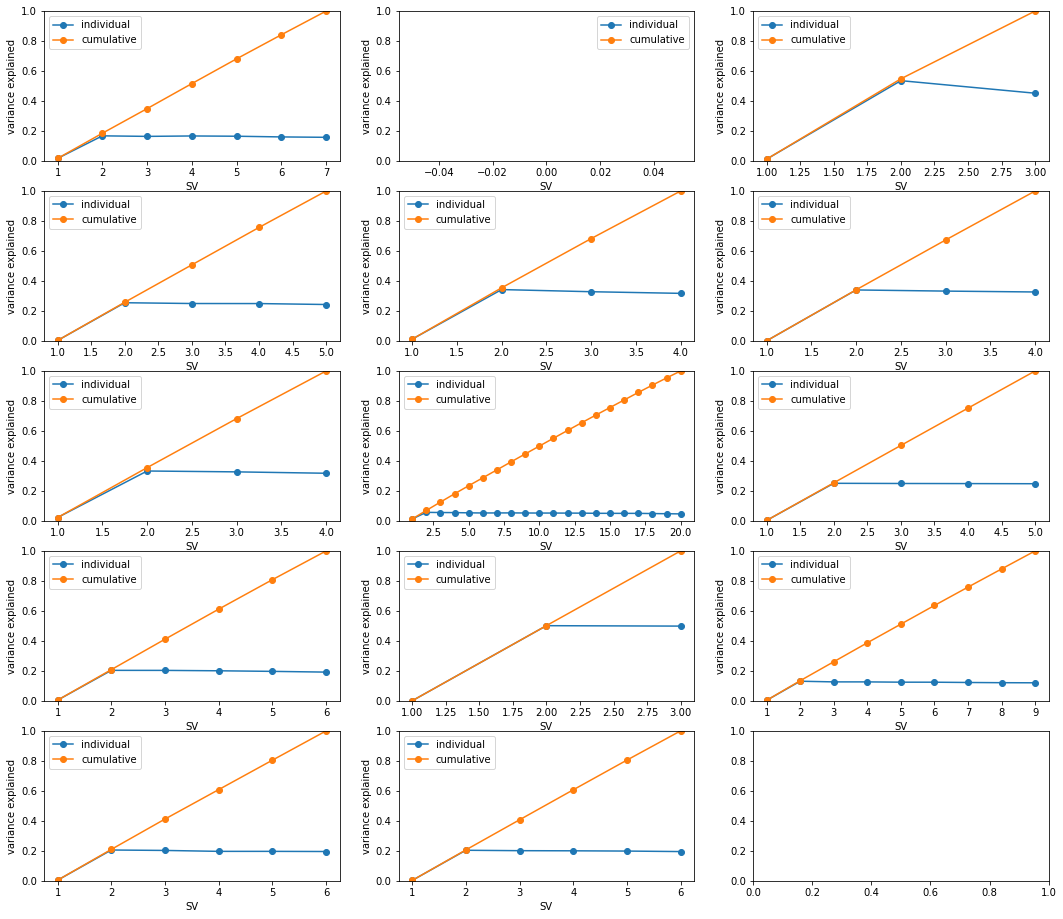

In [54]:
fig, axs = plt.subplots(5, 3, figsize=(18, 16))
axs = axs.ravel()
min_svs = []

for i, pres in enumerate(speeches['president'].unique()):
    speech = speeches[speeches['president'] == pres]['tokenized_2']
    if i != 1:
        vectorizer = TfidfVectorizer(stop_words=my_stop_words,
                                   token_pattern=u'(?ui)\\b[a-z]+\\b',
                                   ngram_range=(2,2))
        vectorizer_tokenized = vectorizer.fit_transform(speech)
        feature_array = vectorizer.get_feature_names()
    else:
        vectorizer = CountVectorizer(stop_words=my_stop_words,
                                    token_pattern=u'(?ui)\\b[a-z]+\\b',
                                    ngram_range=(2,2))
        vectorizer_tokenized = vectorizer.fit_transform(speech)
        feature_array = vectorizer.get_feature_names()
    
    svd_pres = TruncatedSVD(n_components=100)
    svd_pres.fit(vectorizer_tokenized)
    ve_pr = svd_pres.explained_variance_ratio_
    min_svs.append(ve_pr.cumsum() > 0.9)
    
    axs[i].plot(range(1, len(ve_pr)+1), ve_pr, 'o-', label='individual')
    axs[i].plot(range(1, len(ve_pr)+1), ve_pr.cumsum(), 'o-', label='cumulative')
    axs[i].legend()
    axs[i].set_ylim(0, 1)
    axs[i].set_xlabel('SV')
    axs[i].set_ylabel('variance explained')
        

In [55]:
df_all = pd.DataFrame()

for i, pres in enumerate(speeches['president'].unique()):
    speech = speeches[speeches['president'] == pres]['tokenized_2']
    if i != 1:
        vectorizer = TfidfVectorizer(stop_words=my_stop_words,
                                    token_pattern=u'(?ui)\\b[a-z]+\\b',
                                    ngram_range=(2,2))
        vectorizer_tokenized = vectorizer.fit_transform(speech)
        feature_array = vectorizer.get_feature_names()
    else:
        vectorizer = CountVectorizer(stop_words=my_stop_words,
                                    token_pattern=u'(?ui)\\b[a-z]+\\b',
                                    ngram_range=(2,2))
        vectorizer_tokenized = vectorizer.fit_transform(speech)
        feature_array = vectorizer.get_feature_names()
    
    svd_pres = TruncatedSVD(n_components=100)
    svd_pres.fit(vectorizer_tokenized)
    ve_pr = svd_pres.explained_variance_ratio_
    
        
    df_tags = pd.DataFrame()
    d_all = {}
    for i, comp in enumerate(svd_pres.components_):   
        if i != 11:
            best_features = [(feature_array[n], 
                              np.abs(svd_pres.components_[i][n]))
                 for n in np.abs(svd_pres.components_[i].argsort())[::-1]]  
            d_ = {}
            d_["SV_"+str(i)] = best_features[:10]
            d_all.update(d_)
        else:
            break
    df_tags = df_tags.from_dict(d_all)
    df_tags['president'] = pres
    df_all = df_all.append(df_tags)
    display(df_all)

,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


/home/msds2022/jlas/.local/lib/python3.8/site-packages/sklearn/decomposition/_truncated_svd.py:197: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


,SV_0,SV_1,SV_2,SV_3,SV_4,SV_5,SV_6,president,SV_7,SV_8,SV_9,SV_10
0,"(united state, 0.2631211128259443)","(military training, 0.0850591623563173)","(sale tax, 0.35025655664110594)","(trade relation, 0.10665832583097354)","(high commissioner, 0.06651215366102284)","(national assembly, 0.05668082332229728)","(public work, 0.06567565259912586)",Manuel L. Quezon,NaN,NaN,NaN,NaN
1,"(national assembly, 0.1758801584412999)","(military profession, 0.083278505623984)","(income tax, 0.3104162838359924)","(complete independence, 0.08652682165439425)","(trade relation, 0.06368338292557961)","(national economic, 0.05435693738303104)","(settlement administration, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
2,"(commonwealth act, 0.09989062593375939)","(national defense, 0.08026069095637549)","(tax paid, 0.15323724353048387)","(united state, 0.08197902540523236)","(accordance provision, 0.06221105335741898)","(economic council, 0.05435693738303104)","(national park, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
3,"(income tax, 0.07622602387021882)","(chief executive, 0.06907375450130787)","(revenue tax, 0.08756413916027649)","(filipino people, 0.07591642745348375)","(manila railroad, 0.06197301565136929)","(industry agriculture, 0.051849388404303996)","(national land, 0.05303255031867692)",Manuel L. Quezon,NaN,NaN,NaN,NaN
4,"(sale tax, 0.07571563589222699)","(nation defense, 0.06245887921798801)","(tax consumption, 0.08756413916027649)","(president roosevelt, 0.06818722901772616)","(railroad company, 0.055585812986530675)","(group bloc, 0.051849388404303996)","(united state, 0.044334913506110483)",Manuel L. Quezon,NaN,NaN,NaN,NaN
5,"(manila railroad, 0.07304860660059057)","(chief staff, 0.051791676609451213)","(internal revenue, 0.08283313698631763)","(high commissioner, 0.05662316882301357)","(complete independence, 0.053103174255270426)","(report recommendation, 0.051849388404303996)","(treasury certificate, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
6,"(trade relation, 0.07146457260791837)","(national assembly, 0.04838615993478839)","(social justice, 0.07842414594619766)","(independence philippine, 0.046911529675216564)","(investment board, 0.05184254446451582)","(tax commission, 0.051849388404303996)","(public service, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
7,"(railroad company, 0.06954308092272933)","(citizen island, 0.041639252811992)","(tax law, 0.07568940179889895)","(chairman committee, 0.046911529675216564)","(loan investment, 0.05184254446451582)","(section country, 0.04203384749618743)","(office private, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
8,"(high commissioner, 0.06900802686889826)","(able bodied, 0.041639252811992)","(paid consumer, 0.06567310437020737)","(national assembly, 0.04415090941369524)","(national loan, 0.05184254446451582)","(transfer university, 0.04203384749618743)","(average average, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN
9,"(national defense, 0.0690058621931772)","(male population, 0.041639252811992)","(consumption tax, 0.06567310437020737)","(relation united, 0.043223379576262634)","(friar land, 0.049310498348205375)","(high school, 0.041028249827775434)","(private school, 0.04242604025494153)",Manuel L. Quezon,NaN,NaN,NaN,NaN


In [56]:
#df_all.to_csv('svd_presidents.csv')